In [1]:
# gpu
import cudf
import cuml
import rmm
from cuml.manifold import TSNE

# cpu
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from clustergram import Clustergram
from minisom import MiniSom
import numpy as np

In [2]:
rmm.reinitialize(managed_memory=True)
assert(rmm.is_initialized())

In [3]:
df = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/morphometrics/convolutions/conv_68.pq")

In [4]:
df = df.set_index('hindex')

In [5]:
df = df.fillna(0)

In [6]:
data = (df-df.mean())/df.std()

In [7]:
data = cudf.from_pandas(data.fillna(0))

## TSNE

In [8]:
from cuml.manifold import TSNE
import matplotlib.pyplot as plt

In [9]:
tsne = TSNE(n_components = 2, method = 'barnes_hut', random_state=23, perplexity=50, n_neighbors=500, learning_rate=5)
%time embedding = tsne.fit_transform(data)

[W] [10:02:16.668681] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 4 s, sys: 4.36 s, total: 8.37 s
Wall time: 8.32 s


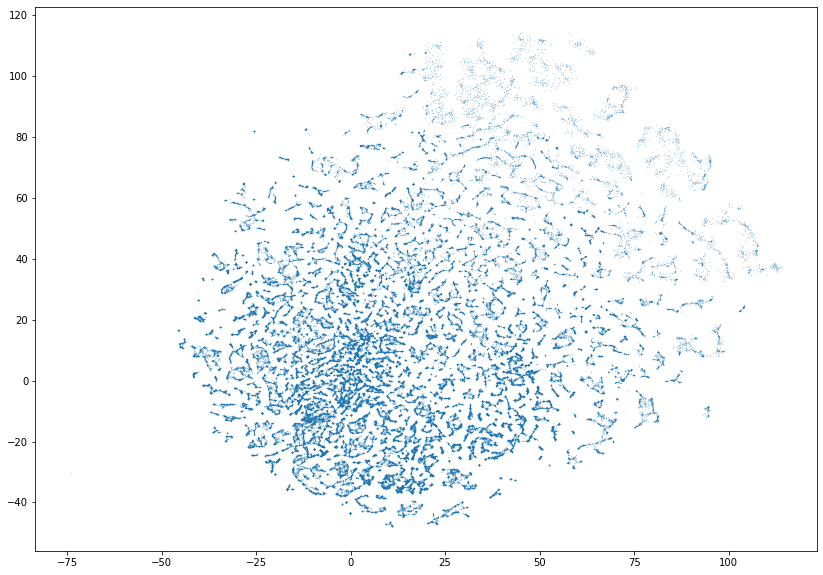

In [10]:
fig, ax = plt.subplots(1, figsize = (14, 10))
scatter = plt.scatter(embedding[0].to_array(), embedding[1].to_array(), s = 0.01)

## PCA

In [12]:
pca_float = PCA(n_components = 2)
pca_float.fit(data.to_pandas().T)

PCA(n_components=2)

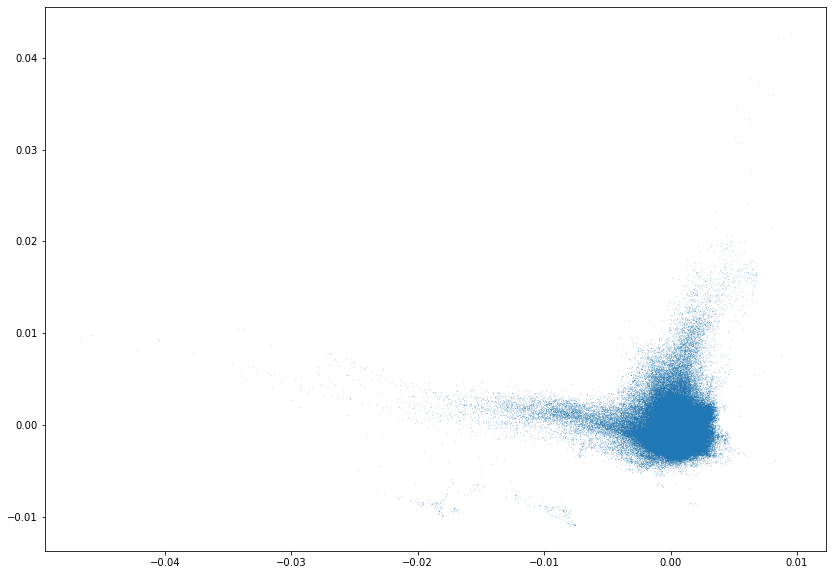

In [13]:
fig, ax = plt.subplots(1, figsize = (14, 10))
scatter = plt.scatter(pca_float.components_[0], pca_float.components_[1], s = .005)

## DBSCAN

In [16]:
dbscan = cuml.DBSCAN(eps=25, min_samples=1000)
dbscan.fit(data)

DBSCAN(eps=25, handle=<cuml.raft.common.handle.Handle object at 0x7fd55407e490>, min_samples=1000, verbose=4, max_mbytes_per_batch=0, output_type='cudf', calc_core_sample_indices=True)

In [17]:
dbscan.labels_.value_counts()

 0    154890
-1       719
dtype: int32

In [18]:
gdf = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_68.pq")

<AxesSubplot:>

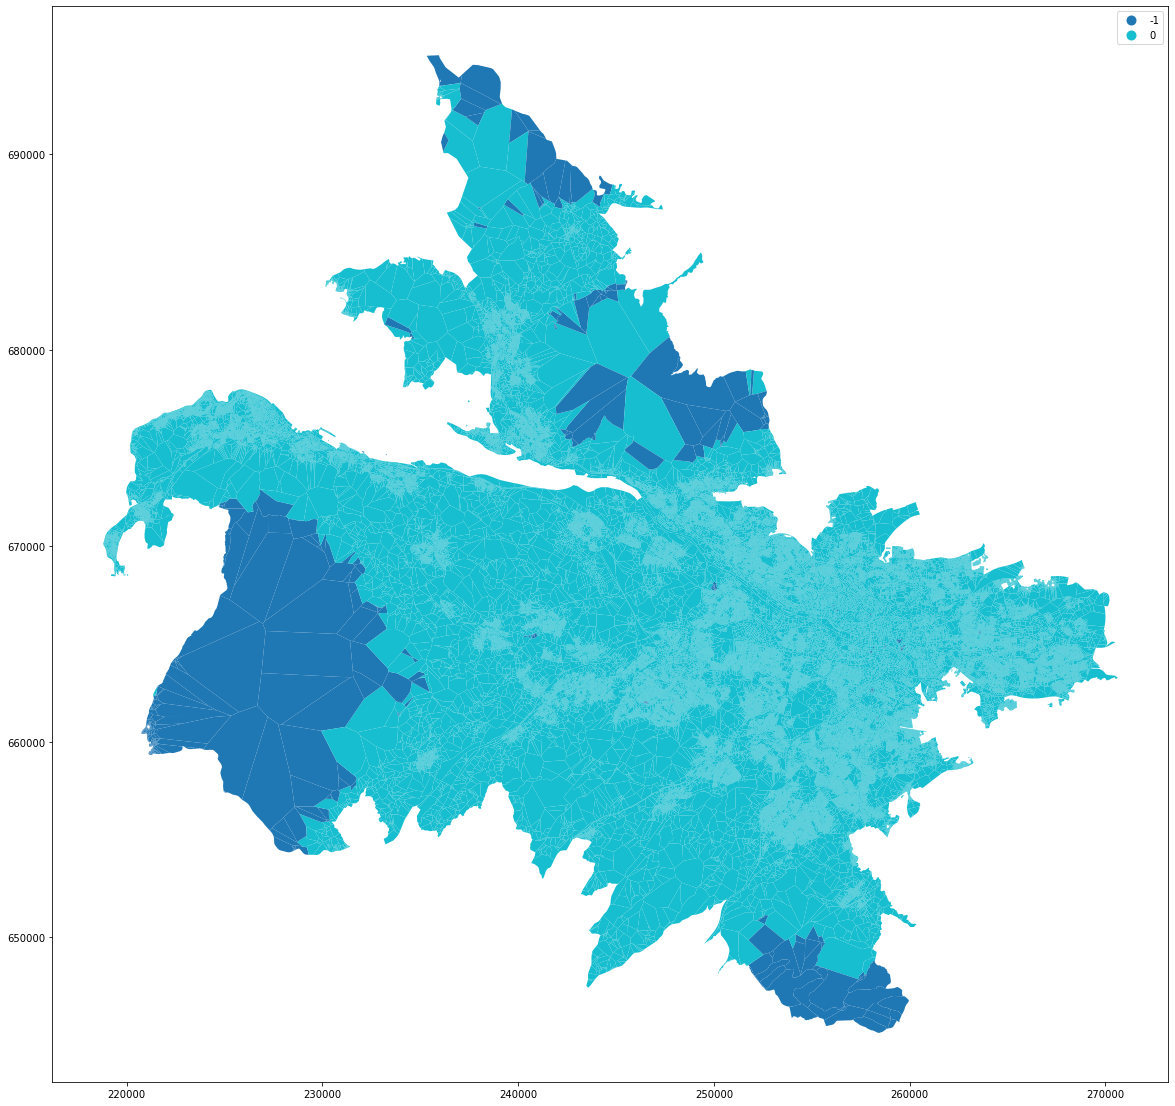

In [19]:
gdf.plot(dbscan.labels_.to_array(), legend=True, figsize=(20, 20), categorical=True)

In [21]:
cg = Clustergram(range(1, 20), backend='cuML', n_init=10)
cg.fit(data)

PCA computed in 0.6204185485839844 seconds.
K=1 fitted in 2.5283796787261963 seconds.
K=2 fitted in 3.9219841957092285 seconds.
K=3 fitted in 5.212741851806641 seconds.
K=4 fitted in 5.78128457069397 seconds.
K=5 fitted in 5.934966087341309 seconds.
K=6 fitted in 9.333116054534912 seconds.
K=7 fitted in 7.952919006347656 seconds.
K=8 fitted in 12.635532140731812 seconds.
K=9 fitted in 16.096463441848755 seconds.
K=10 fitted in 13.722727537155151 seconds.
K=11 fitted in 19.421172857284546 seconds.
K=12 fitted in 15.979103088378906 seconds.
K=13 fitted in 20.954347848892212 seconds.
K=14 fitted in 22.544381141662598 seconds.
K=15 fitted in 27.48892831802368 seconds.
K=16 fitted in 18.474432468414307 seconds.
K=17 fitted in 24.707815408706665 seconds.
K=18 fitted in 30.156665325164795 seconds.
K=19 fitted in 20.554524660110474 seconds.


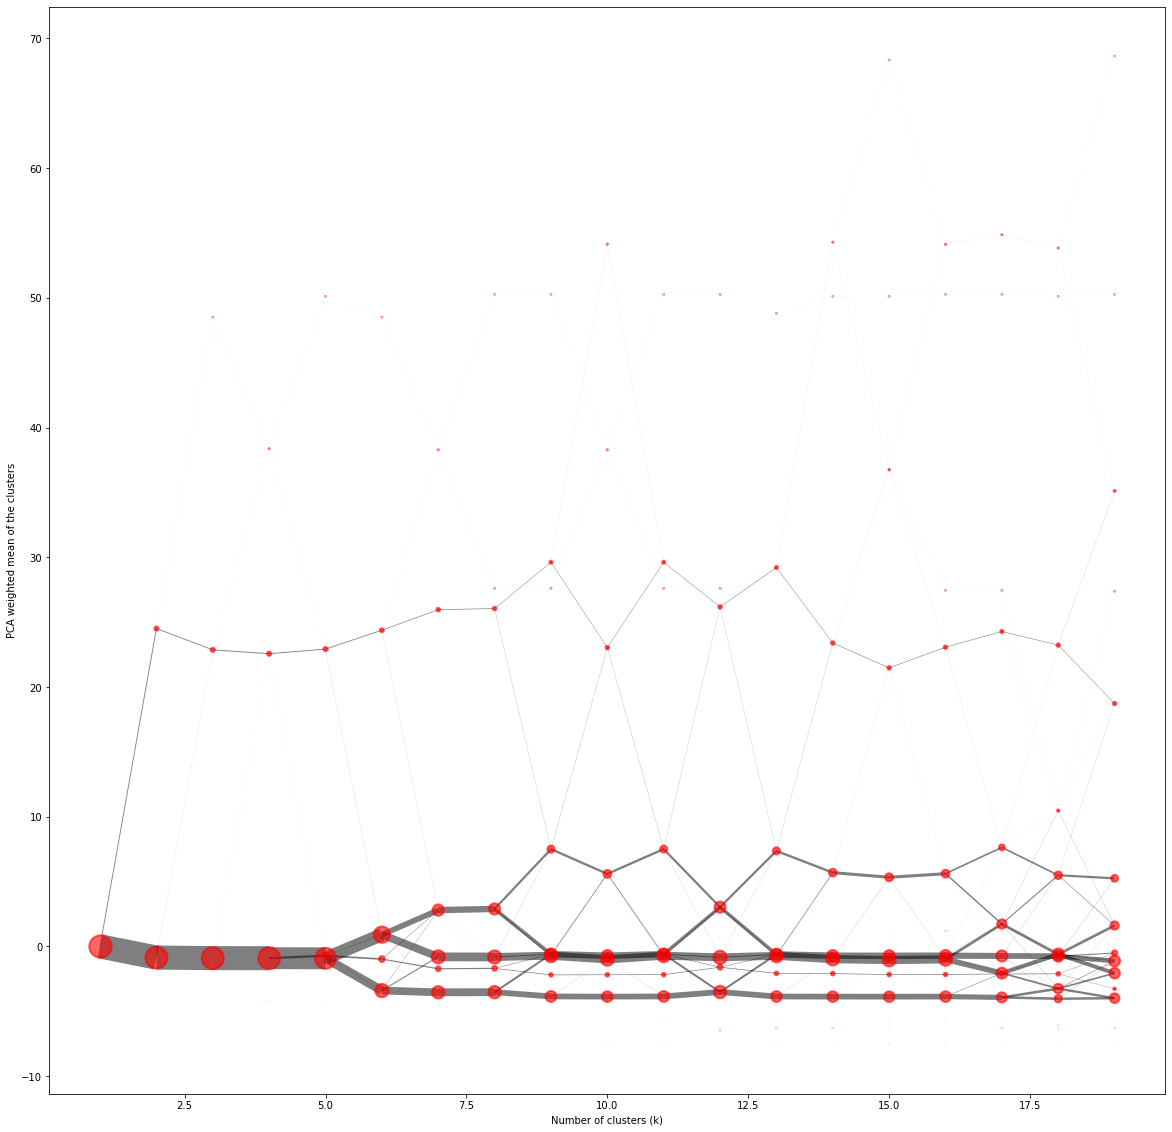

In [22]:
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

In [23]:
out_rm = cuml.KMeans(n_clusters=2, n_init=10).fit(data)
out_rm.labels_.value_counts()

1    150297
0      5312
dtype: int32

PCA computed in 0.12816238403320312 seconds.
K=1 fitted in 2.48162579536438 seconds.
K=2 fitted in 3.4177932739257812 seconds.
K=3 fitted in 4.41484808921814 seconds.
K=4 fitted in 5.628169536590576 seconds.
K=5 fitted in 5.920827627182007 seconds.
K=6 fitted in 7.5474183559417725 seconds.
K=7 fitted in 8.500653743743896 seconds.
K=8 fitted in 10.06291127204895 seconds.
K=9 fitted in 10.015550136566162 seconds.
K=10 fitted in 11.057960510253906 seconds.
K=11 fitted in 10.950886726379395 seconds.
K=12 fitted in 12.391627073287964 seconds.
K=13 fitted in 14.87376618385315 seconds.
K=14 fitted in 14.32203483581543 seconds.
K=15 fitted in 14.89663314819336 seconds.
K=16 fitted in 20.673580408096313 seconds.
K=17 fitted in 21.509401321411133 seconds.
K=18 fitted in 13.537689447402954 seconds.
K=19 fitted in 17.991295337677002 seconds.


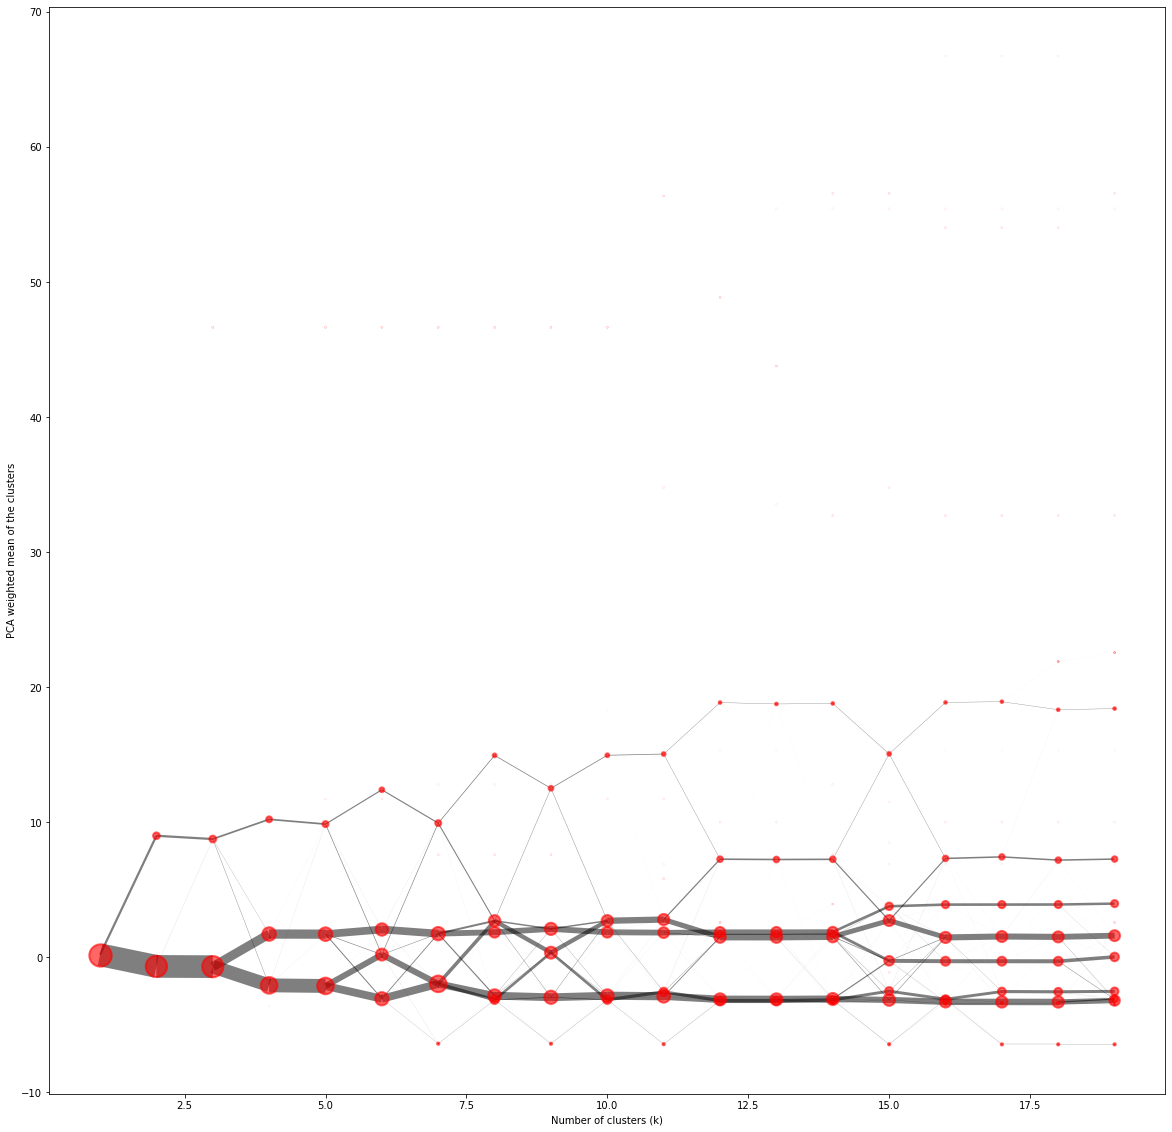

In [24]:
cg = Clustergram(range(1, 20), backend='cuML', n_init=10)
cg.fit(data[out_rm.labels_ == 1])
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

(-10.0, 25.0)

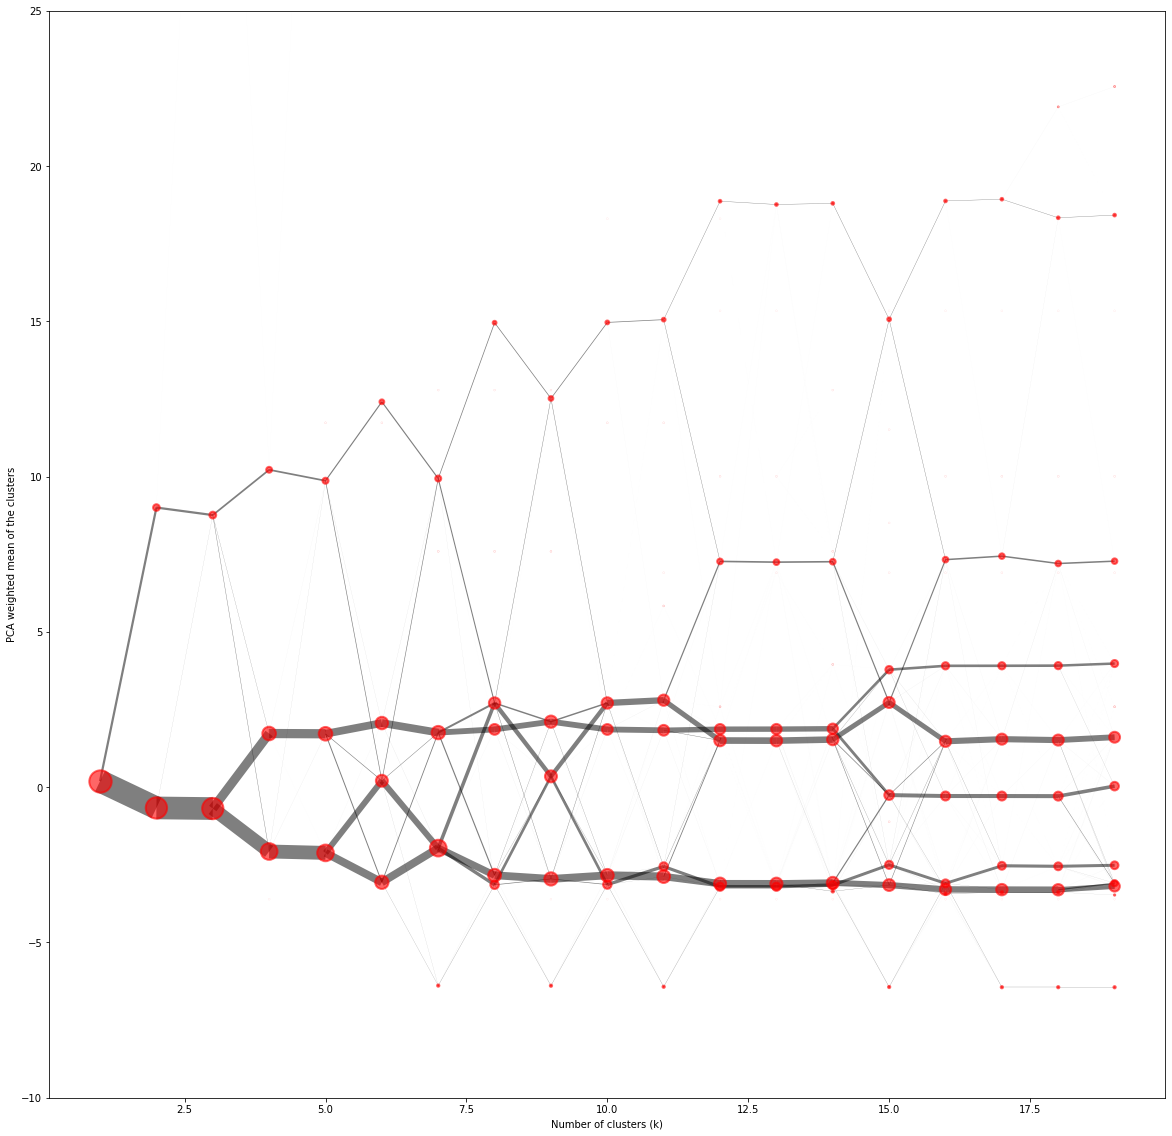

In [30]:
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-10, 25)

In [25]:
km = cuml.KMeans(n_clusters=6, n_init=10).fit(data[out_rm.labels_ == 1])

<AxesSubplot:>

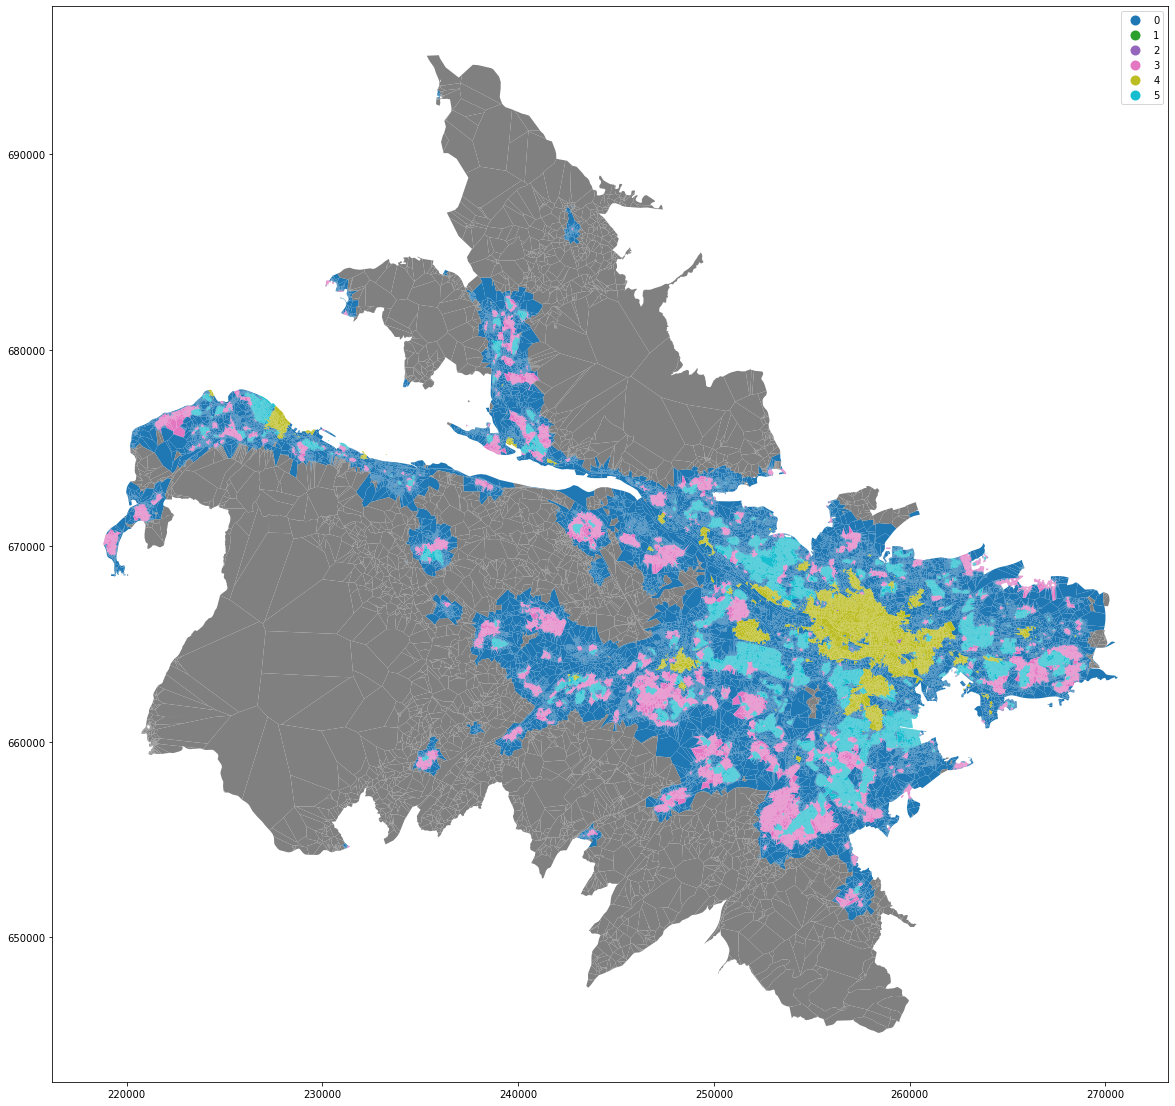

In [28]:
ax = gdf[out_rm.labels_.to_array() == 1].plot(km.labels_.to_array(), legend=True, figsize=(20, 20), categorical=True)
gdf[out_rm.labels_.to_array() != 1].plot(ax=ax, color='grey')

<AxesSubplot:>

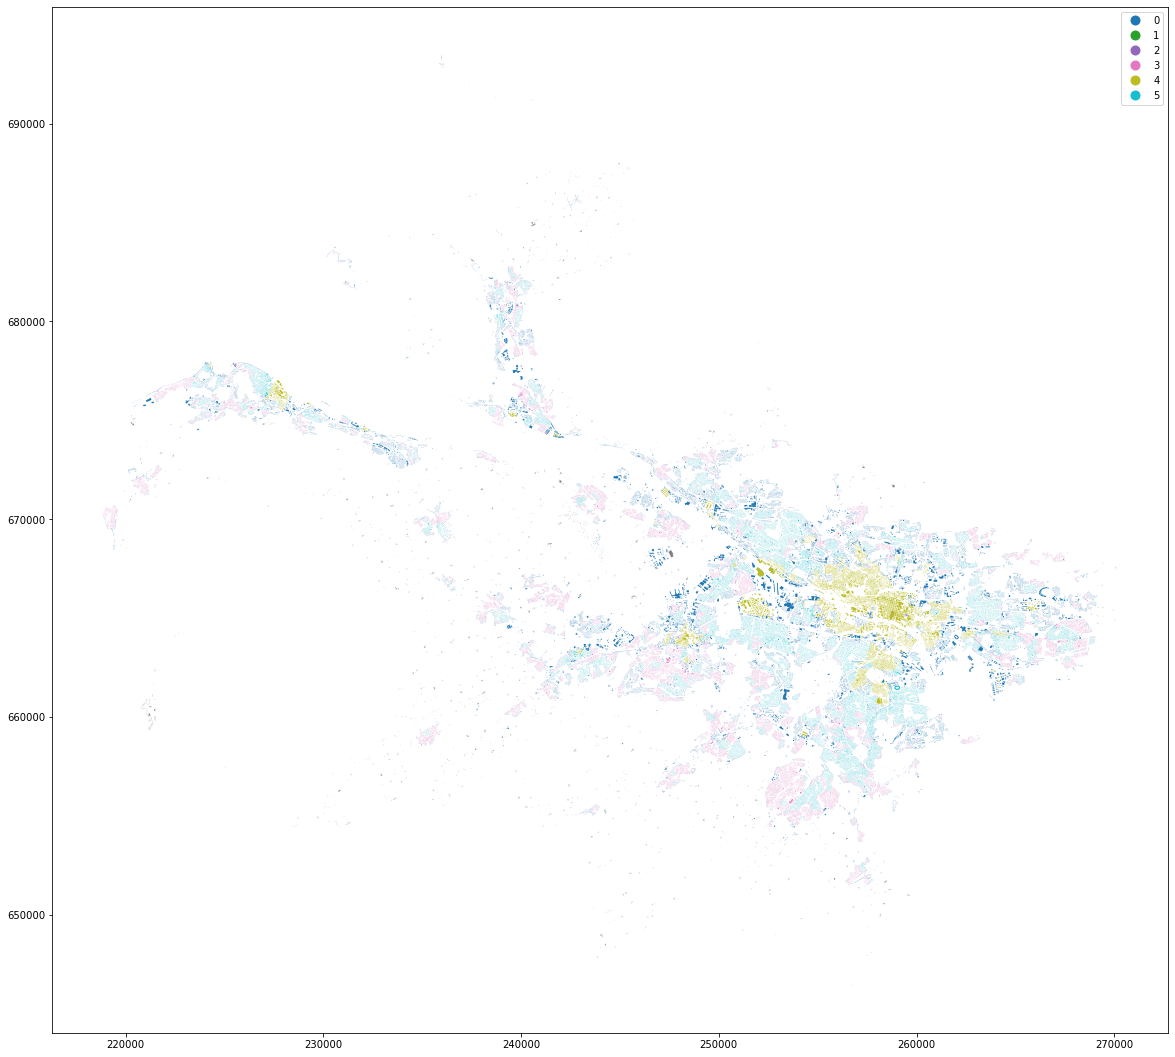

In [29]:
ax = gdf[out_rm.labels_.to_array() == 1].set_geometry('buildings').plot(km.labels_.to_array(), legend=True, figsize=(20, 20), categorical=True)
gdf[out_rm.labels_.to_array() != 1].set_geometry('buildings').plot(ax=ax, color='grey')

In [31]:
km = cuml.KMeans(n_clusters=15, n_init=10).fit(data[out_rm.labels_ == 1])

<AxesSubplot:>

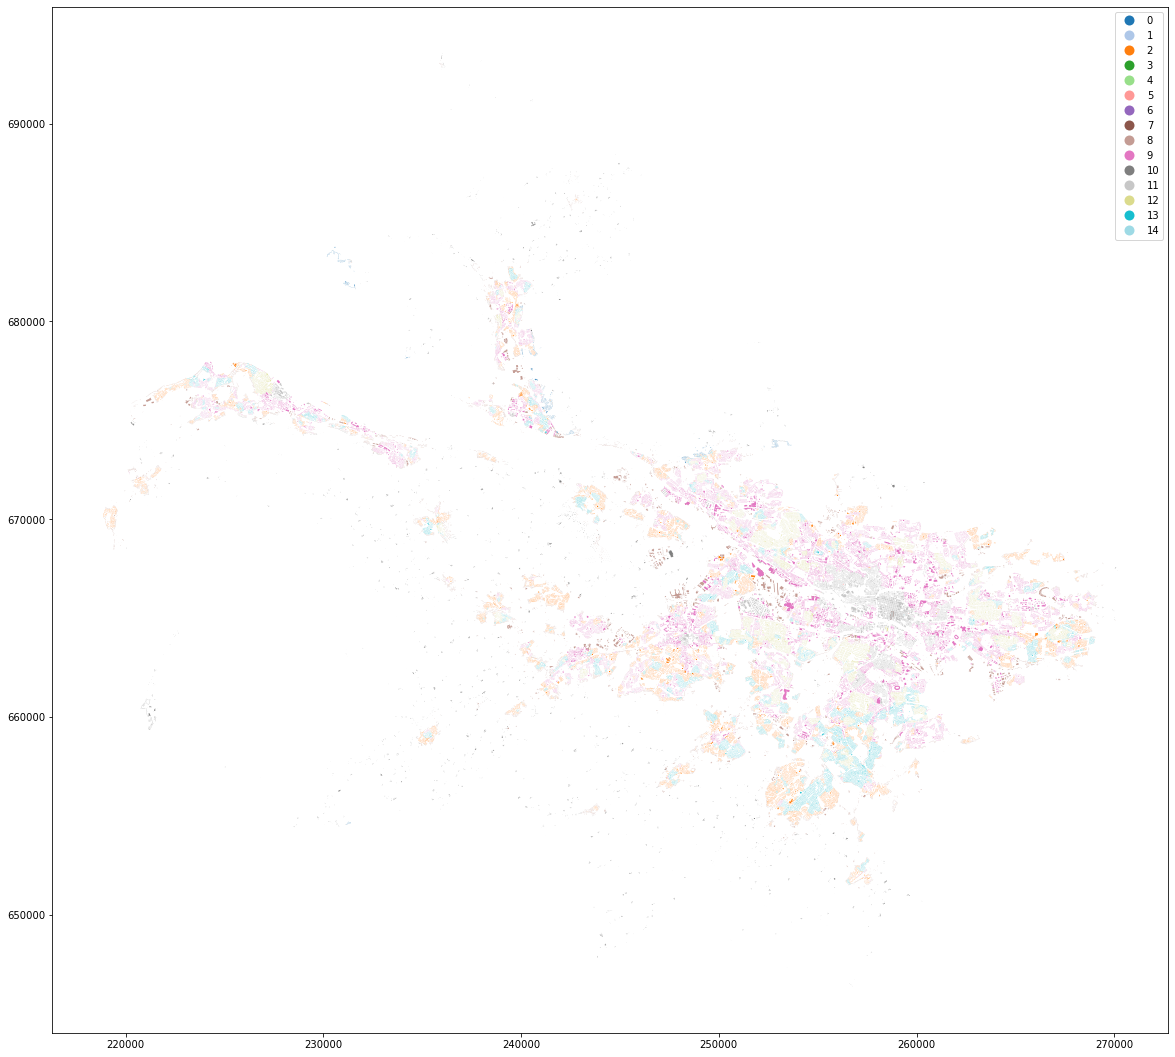

In [35]:
ax = gdf[out_rm.labels_.to_array() == 1].set_geometry('buildings').plot(km.labels_.to_array(), legend=True, figsize=(20, 20), categorical=True, cmap='tab20')
gdf[out_rm.labels_.to_array() != 1].set_geometry('buildings').plot(ax=ax, color='grey')

In [34]:
km.labels_.value_counts()

2     42276
9     36909
13    28423
8     19953
12    16920
11     4249
0      1536
7        10
10        7
5         5
1         2
3         2
6         2
14        2
4         1
dtype: int32

In [36]:
km = cuml.KMeans(n_clusters=15, n_init=10).fit(data)

In [37]:
km.labels_.value_counts()

0     50890
11    39998
8     35585
14    20116
12     4203
7      3868
13      670
10      133
6       127
9         9
1         3
3         2
4         2
5         2
2         1
dtype: int32

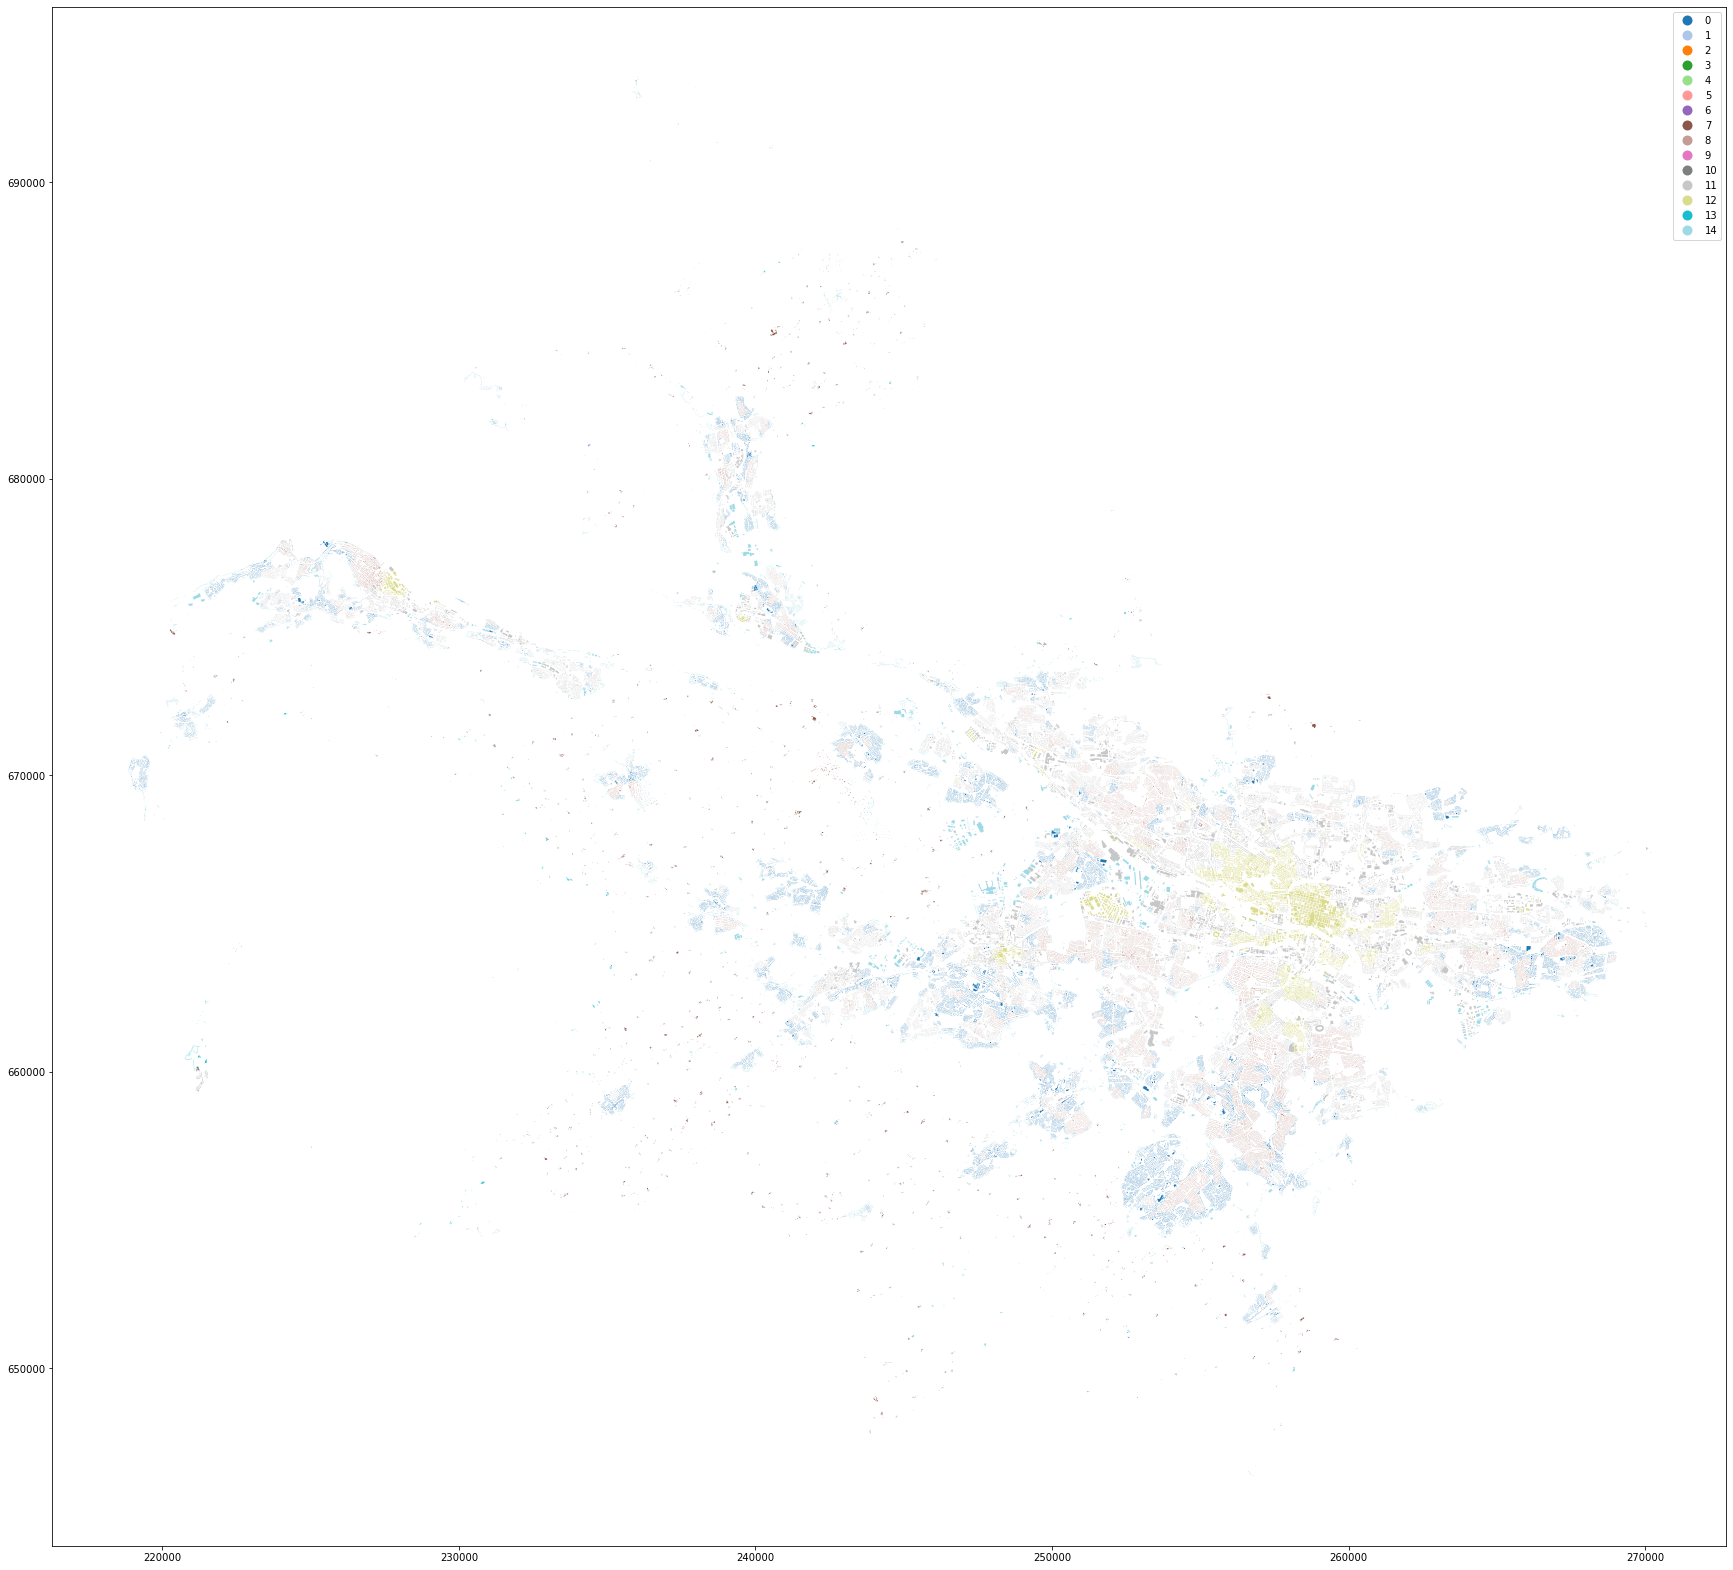

In [50]:
ax = gdf.set_geometry('buildings').plot(km.labels_.to_array(), legend=True, figsize=(30, 30), categorical=True, cmap='tab20')

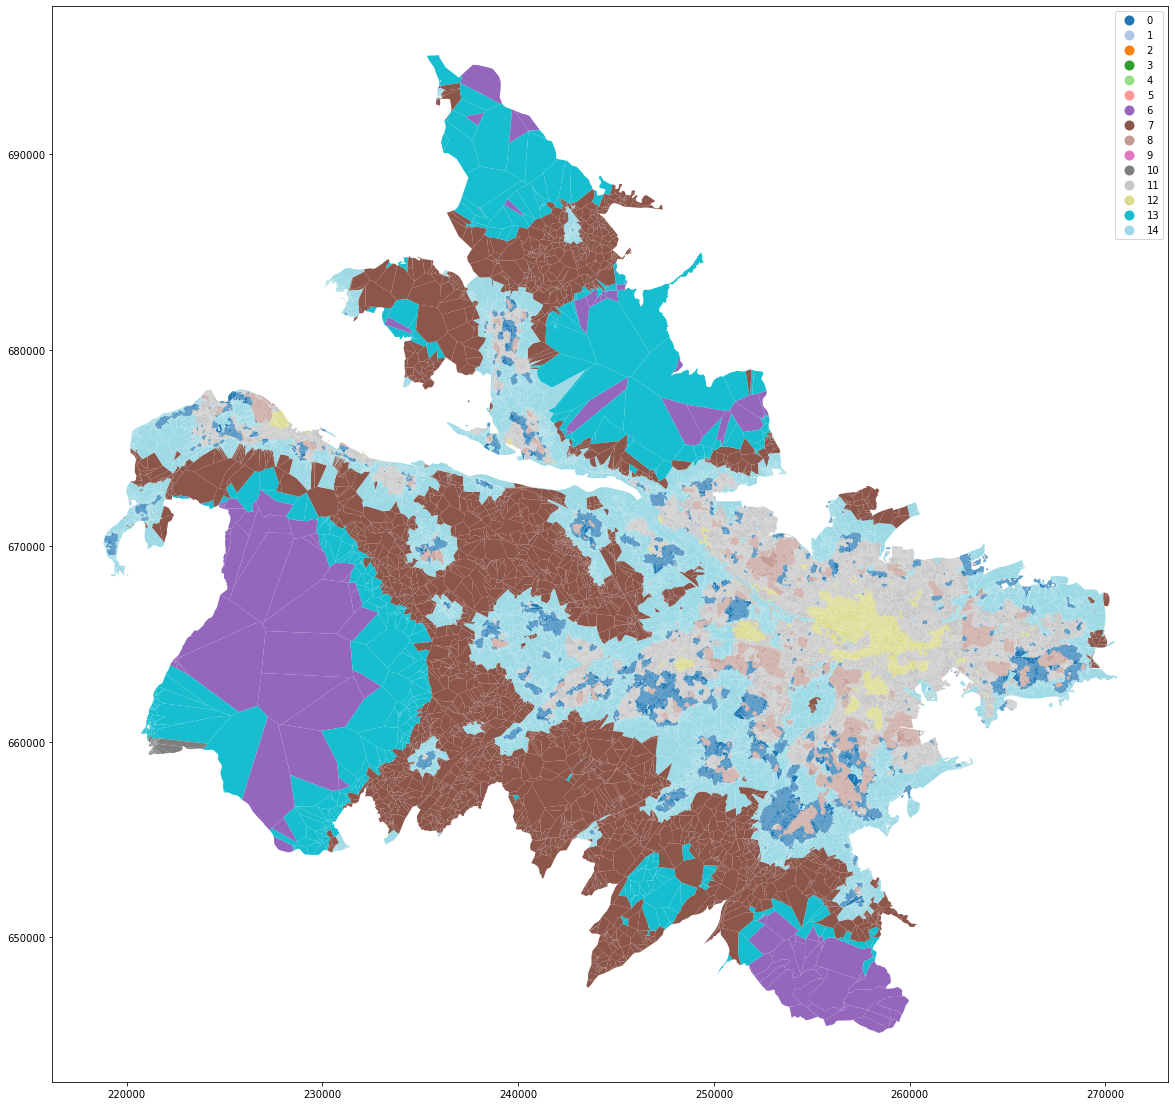

In [39]:
ax = gdf.plot(km.labels_.to_array(), legend=True, figsize=(20, 20), categorical=True, cmap='tab20')

In [41]:
som_shape = (3, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.25,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(data.as_matrix(), 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 10.822450777167504


In [43]:
winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)

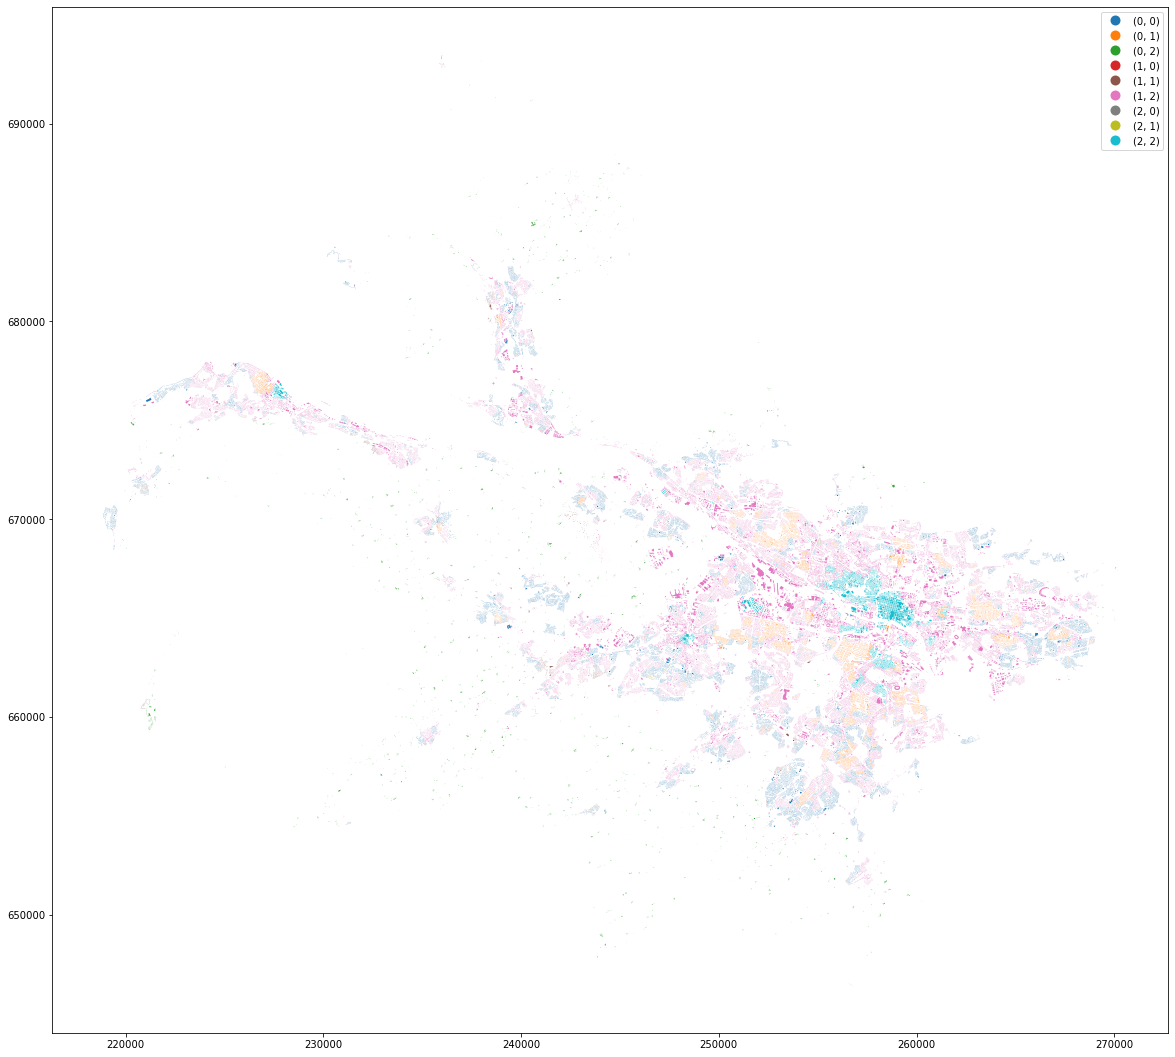

In [44]:
ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(20, 20), categorical=True)

In [45]:
som_shape = (4, 4)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.25,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(data.as_matrix(), 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 10.204360744053766


In [46]:
winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)

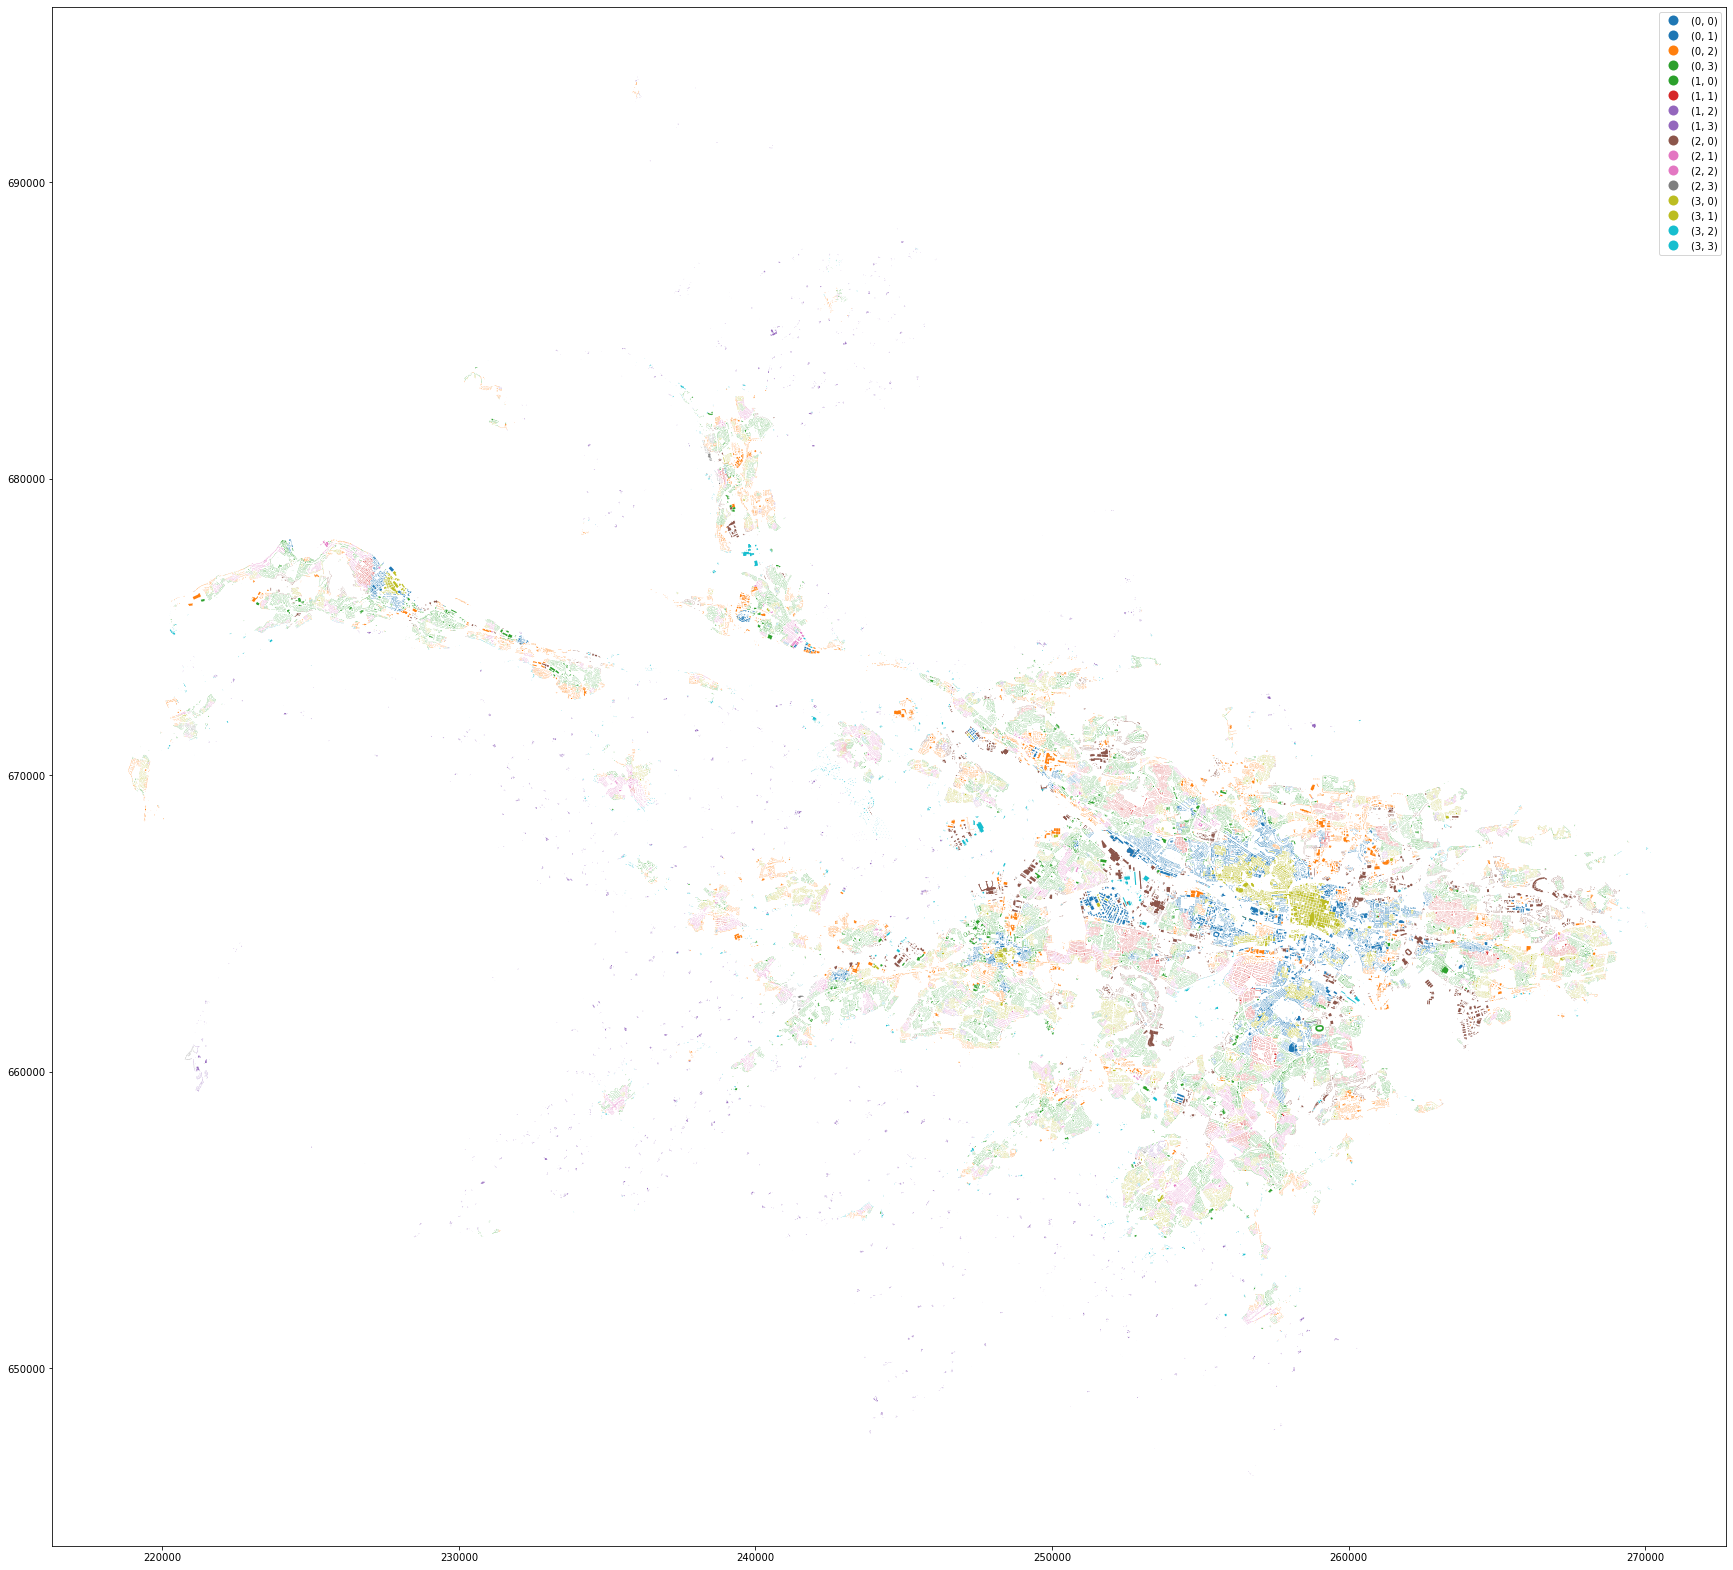

In [47]:
ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(30, 30), categorical=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 10.518804957085381


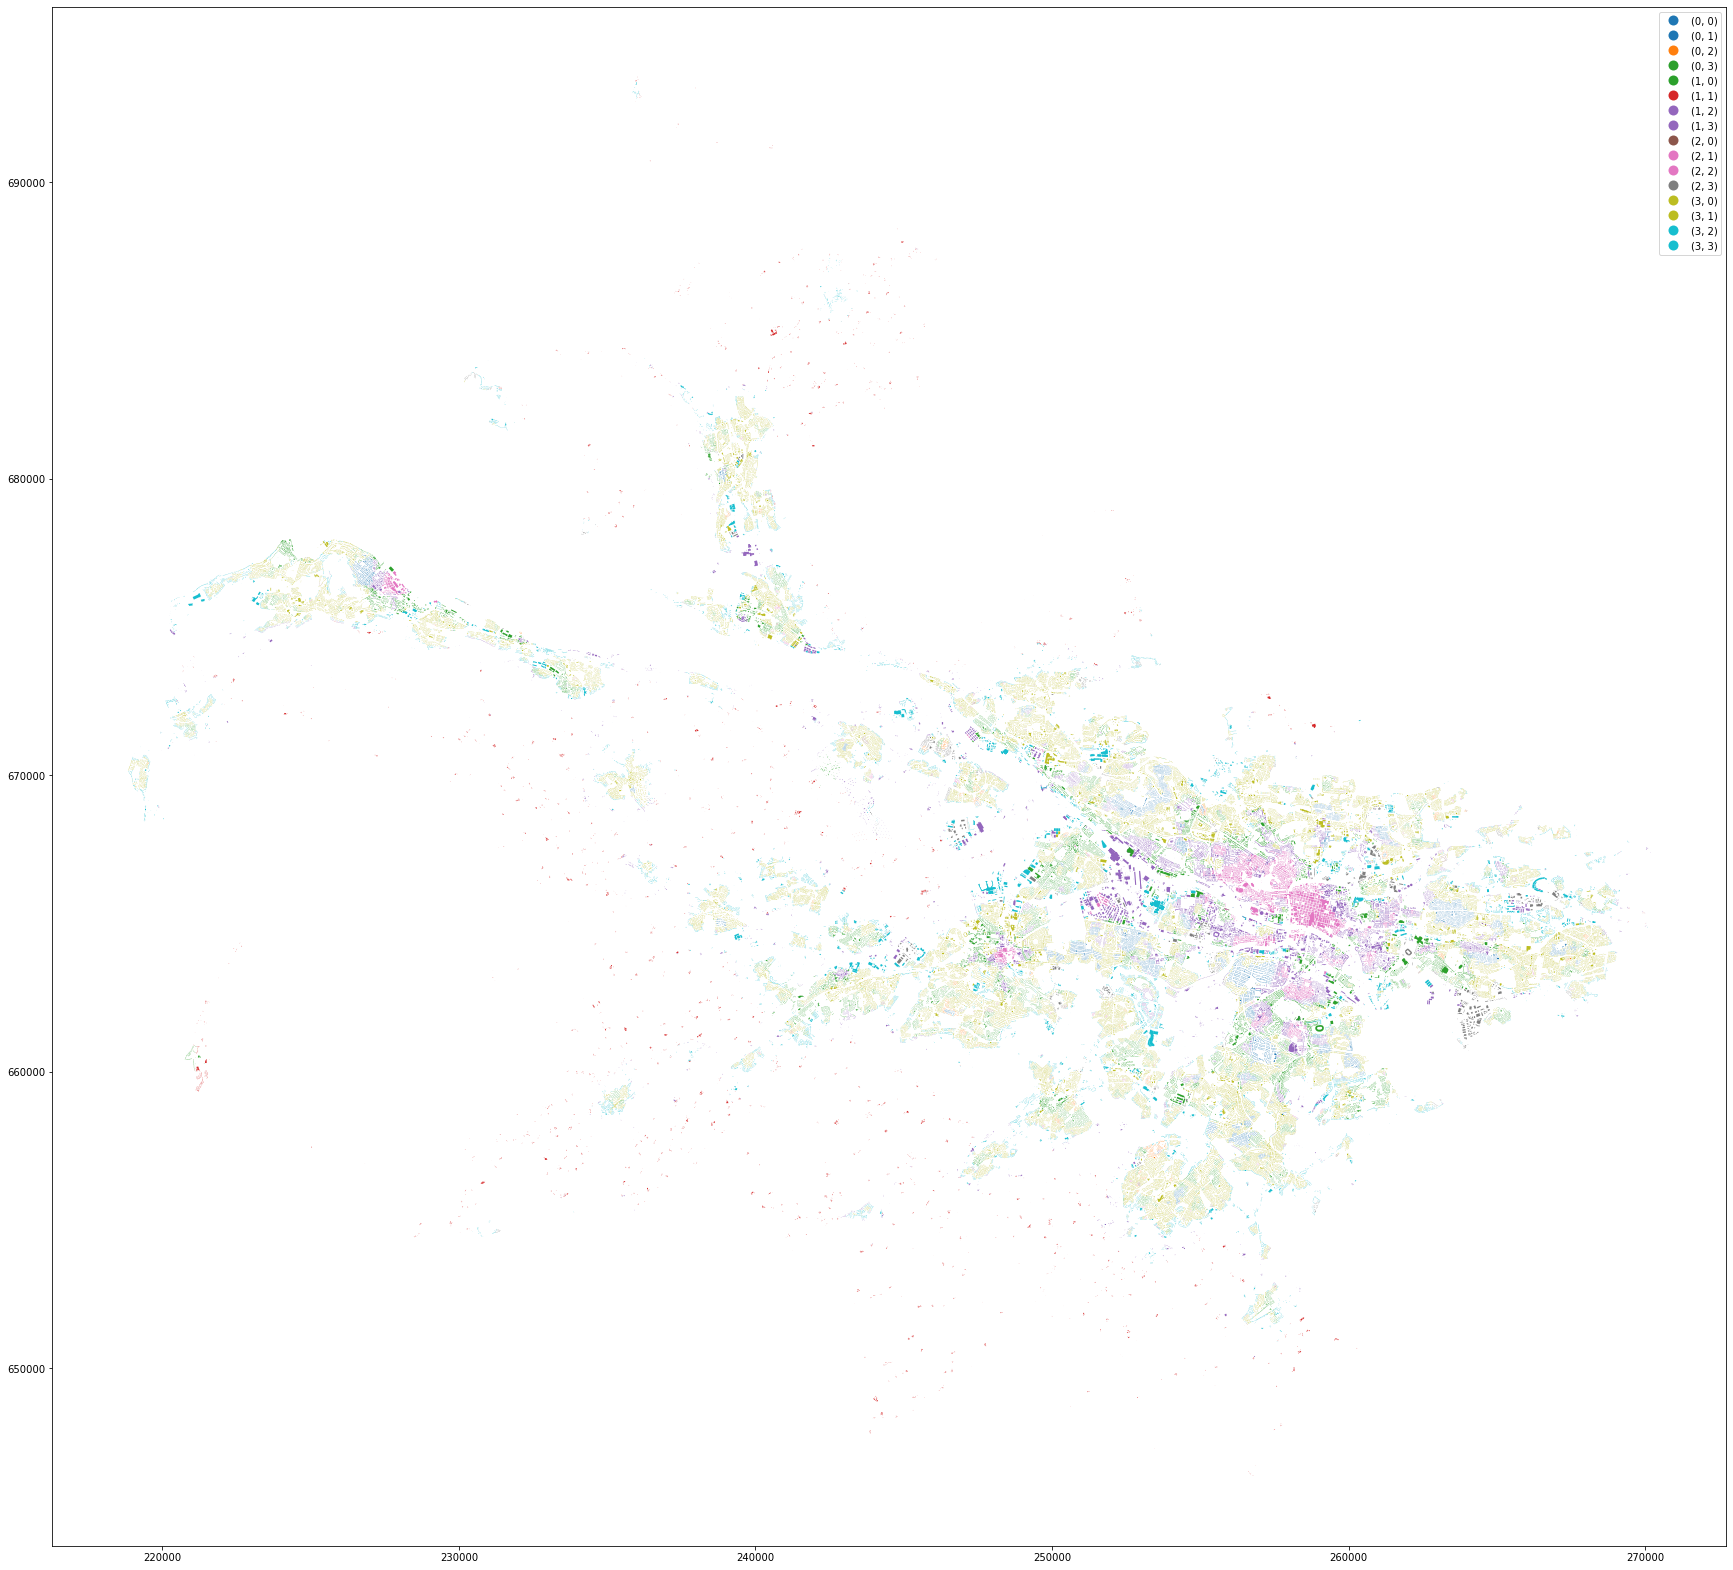

In [48]:
som_shape = (4, 4)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(data.as_matrix(), 50000, verbose=True)
winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)
ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(30, 30), categorical=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 10.97337545200437


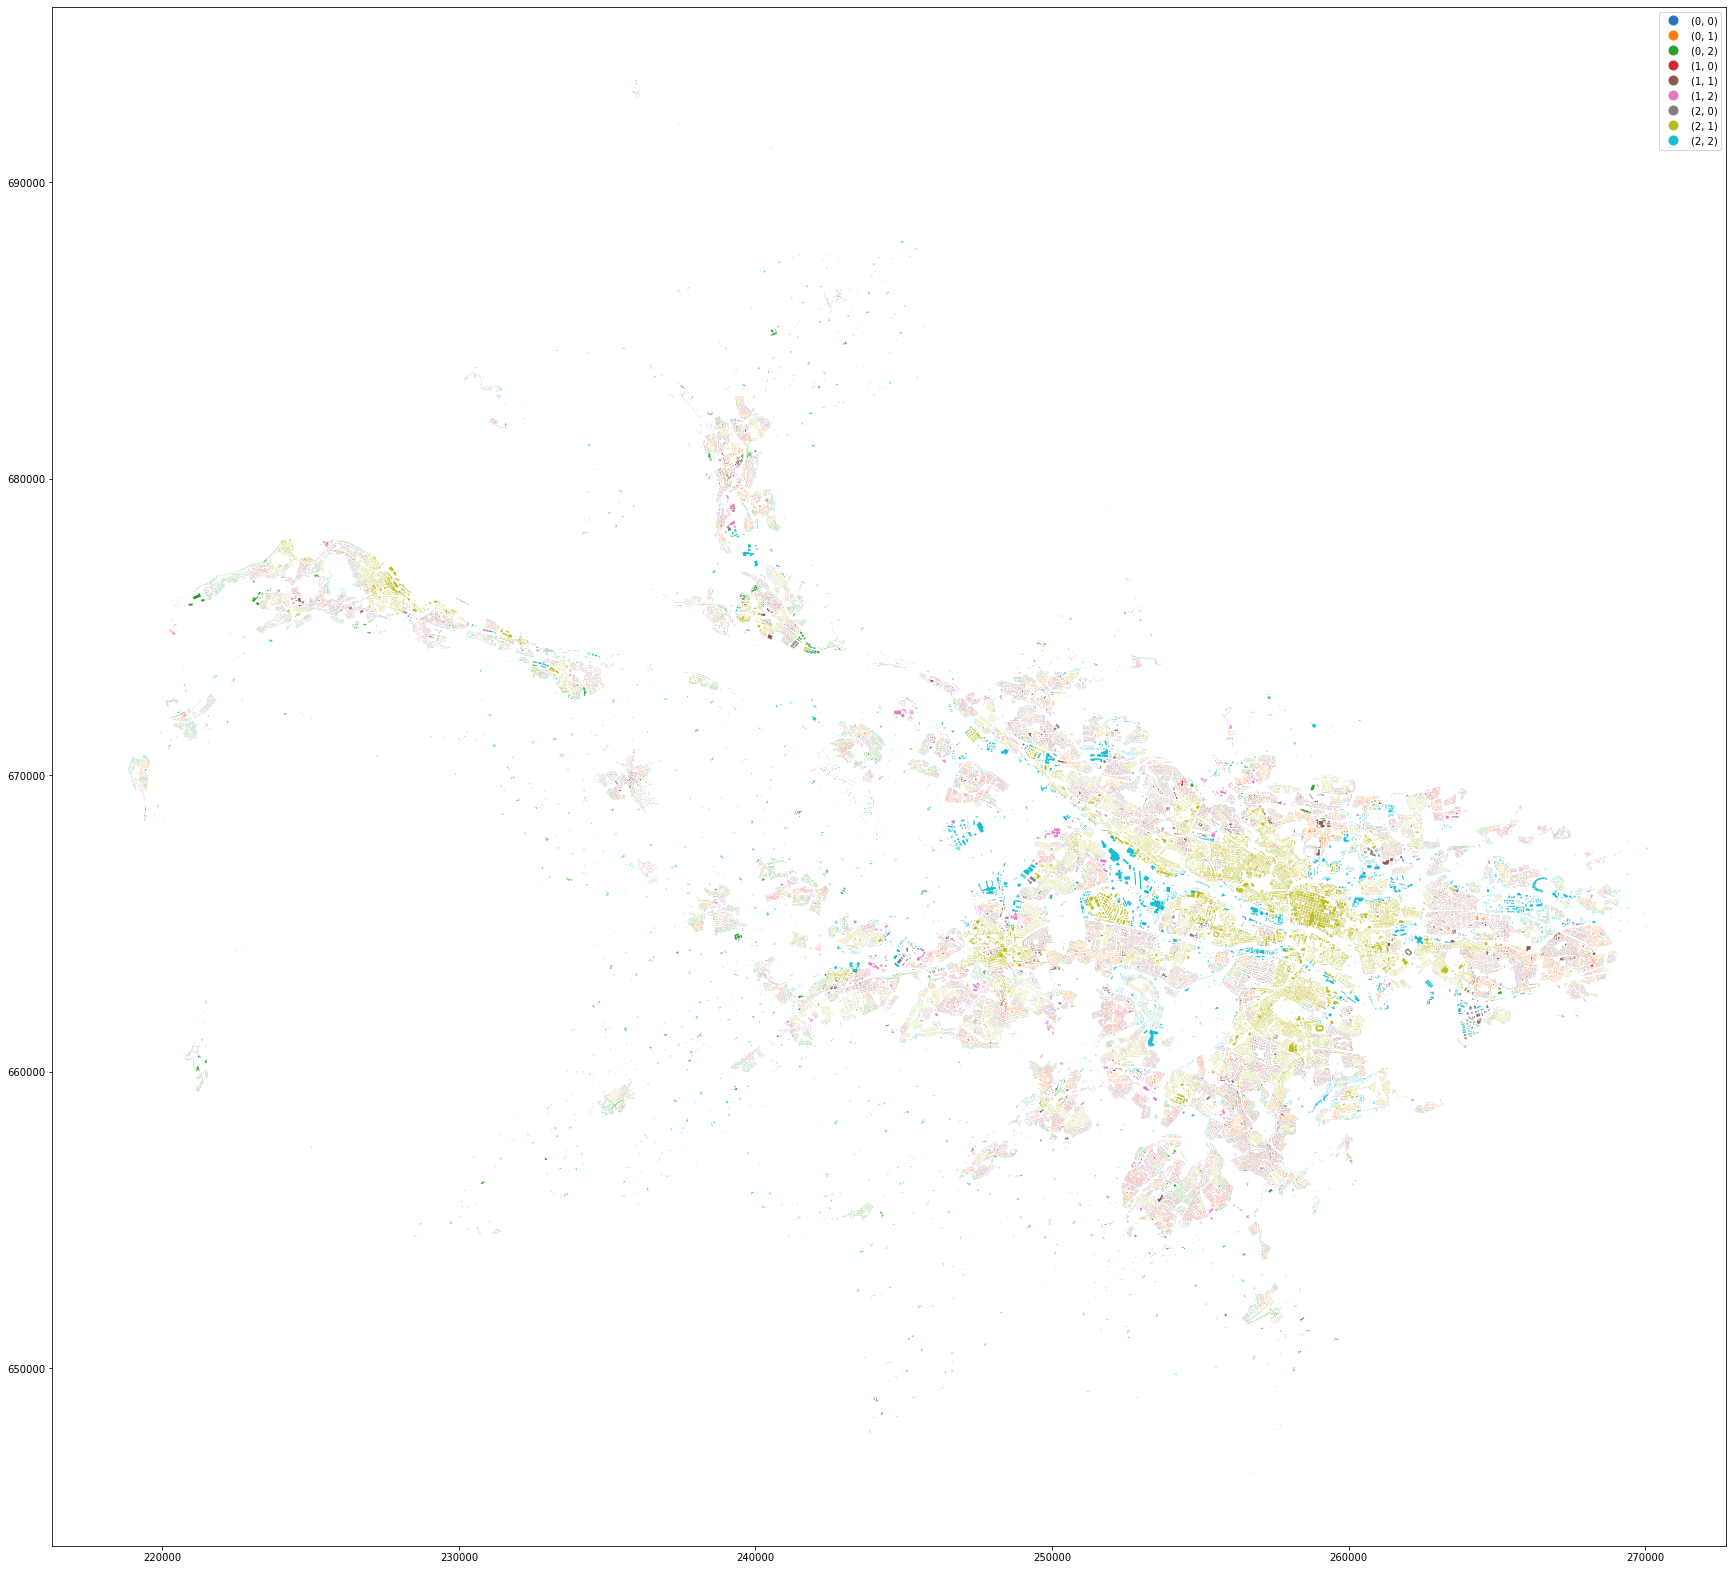

In [51]:
som_shape = (3, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=1, learning_rate=.25,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(data.as_matrix(), 50000, verbose=True)
winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)
ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(30, 30), categorical=True)

In [57]:
som_shape = (3, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=1, learning_rate=1,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(data.as_matrix(), 5000, verbose=True)
# winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
# hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)
# ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(30, 30), categorical=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 11.923051455229523


In [54]:
som.topographic_error(data.as_matrix())

0.05661626255550772

In [55]:
som.quantization_error(data.as_matrix())

11.268126324053172

In [56]:
help(som)

Help on MiniSom in module minisom object:

class MiniSom(builtins.object)
 |  MiniSom(x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=<function asymptotic_decay at 0x7fd713351310>, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=<function asymptotic_decay at 0x7fd713351310>, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=None)
 |      Initializes a Self Organizing Maps.
 |      
 |      A rule of thumb to set the size of the grid for a dimensionality
 |      reduction task is that it should contain 5*sqrt(N) neurons
 |      where N is the number of samples in the dataset to analyze.
 |      
 |      E.g. if your dataset has 150 samples, 5*sqrt(150) = 61.23
 |      hence a map 8-by-8 should perform well.
 |      
 |      Parameters
 |      ---

In [64]:
%%time
som_comp = pd.DataFrame(columns=['shape', 'topology', 'sigma', 'learning rate', 'topographic_error', 'quantization_error'])
i = 0
for shape in [(3, 3), (3, 4), (4, 4), (4, 5), (5, 5)]:
    for topology in ['rectangular', 'hexagonal']:
        for sigma in [.1, .25, 5, .75, 1]:
            for rate in [.1, .25, 5, .75, 1]:
                som = MiniSom(shape[0], shape[1], data.shape[1], sigma=sigma, learning_rate=rate,
                              neighborhood_function='gaussian', random_seed=10, topology=topology)
                som.train_batch(data.as_matrix(), 5000, verbose=False)
                if topology == 'hexagonal':
                    som_comp.loc[i] = [shape, topology, sigma, rate, None, som.quantization_error(data.as_matrix())]
                else:
                    som_comp.loc[i] = [shape, topology, sigma, rate, som.topographic_error(data.as_matrix()), som.quantization_error(data.as_matrix())]
                i += 1

/opt/conda/envs/rapids/lib/python3.8/site-packages/minisom.py:154: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')
/opt/conda/envs/rapids/lib/python3.8/site-packages/numpy/linalg/linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/opt/conda/envs/rapids/lib/python3.8/site-packages/numpy/linalg/linalg.py:2561: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/opt/conda/envs/rapids/lib/python3.8/site-packages/minisom.py:329: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


CPU times: user 7min 8s, sys: 6min 31s, total: 13min 40s
Wall time: 4min 23s


In [67]:
som_comp.loc[som_comp.quantization_error.idxmin()]

shape                    (5, 5)
topology              hexagonal
sigma                       0.1
learning rate               0.1
topographic_error          None
quantization_error      10.2487
Name: 225, dtype: object

In [68]:
som_comp.loc[som_comp.quantization_error.idxmax()]

shape                      (3, 3)
topology                hexagonal
sigma                         0.1
learning rate                   5
topographic_error            None
quantization_error    6.33425e+08
Name: 27, dtype: object

In [71]:
som_comp.loc[som_comp.topographic_error.dropna().astype(float).idxmin()]

shape                      (3, 3)
topology              rectangular
sigma                           5
learning rate                   5
topographic_error               0
quantization_error            NaN
Name: 12, dtype: object

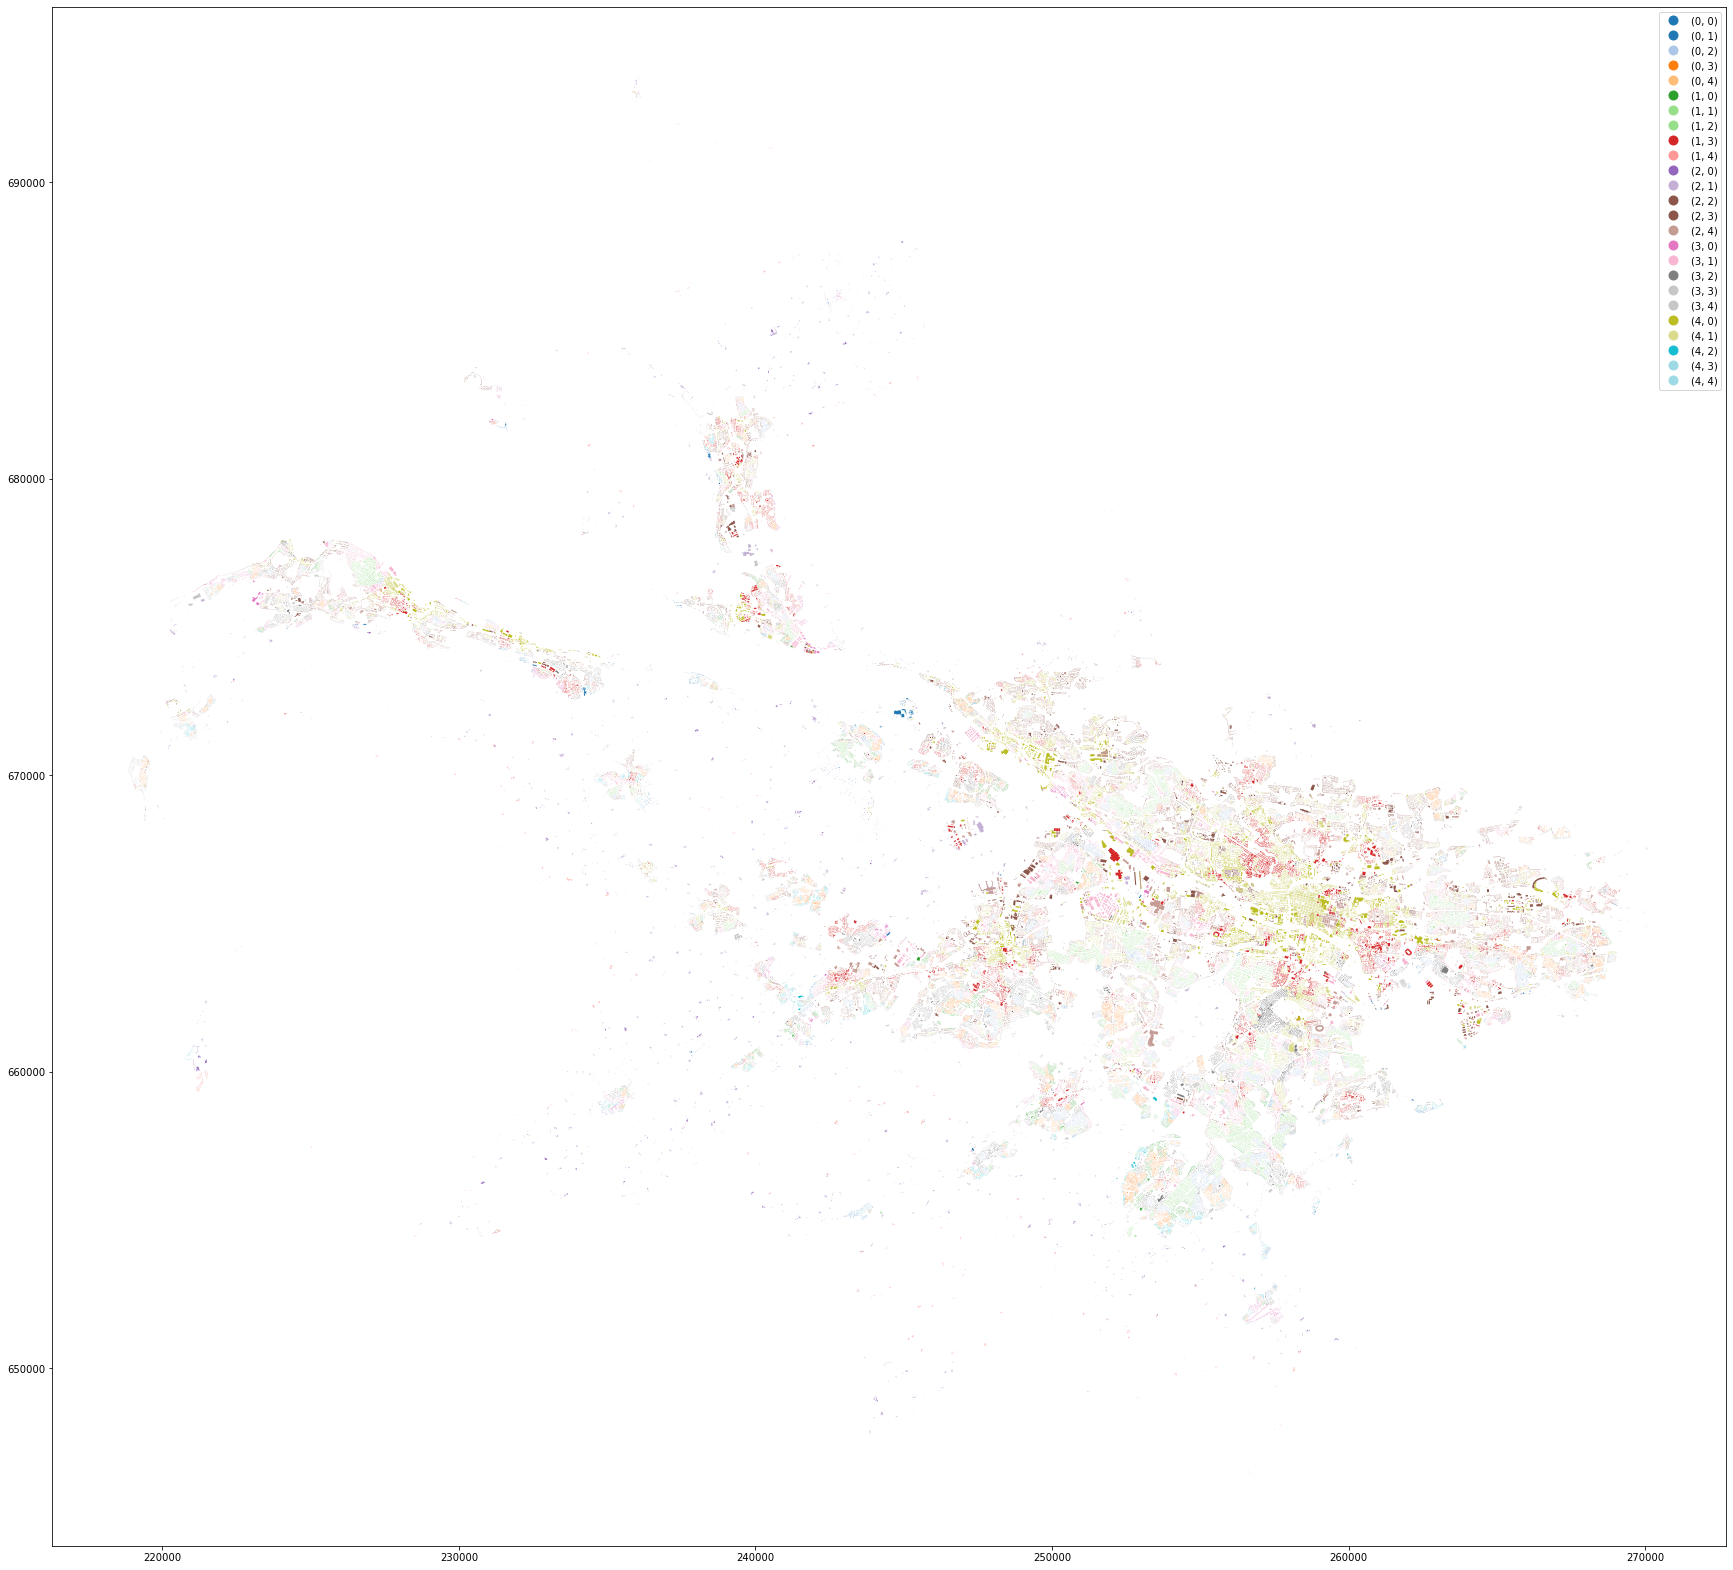

In [74]:
som_shape = (5, 5)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.1, learning_rate=.1,
              neighborhood_function='gaussian', random_seed=10, topology="hexagonal")
som.train_batch(data.as_matrix(), 5000, verbose=True)
winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)
ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(30, 30), categorical=True, cmap="tab20")

In [ ]:
som_shape = (4, 4)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.25, learning_rate=.25,
              neighborhood_function='gaussian', random_seed=10, topology="hexagonal")
som.train_batch(data.as_matrix(), 5000, verbose=True)
winner_coordinates = np.array([som.winner(x) for x in data.as_matrix()])
hashes = np.apply_along_axis(lambda x: str(tuple(x)), 1, winner_coordinates)
ax = gdf.set_geometry('buildings').plot(hashes, legend=True, figsize=(30, 30), categorical=True, cmap="tab20")

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 12.330161138201133
